In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, gaussian_kde

dir = os.getcwd()
output_path_full = os.path.join(dir, 'history.parquet')

data = pd.read_parquet(output_path_full, columns=['open', 'high', 'low', 'close', 'volume'])
# data = data[-(60*24*25*1):]
data = data[data['volume'] != 0]
# data = data.reset_index(drop=True)
print(data.head())

                 open     high      low    close  volume
201906171300  7537.25  7537.25  7535.50  7535.50     7.0
201906171301  7535.25  7535.25  7535.25  7535.25     1.0
201906171302  7535.75  7536.25  7535.75  7536.25     2.0
201906171303  7536.00  7536.00  7536.00  7536.00     1.0
201906171304  7536.50  7536.50  7536.50  7536.50     1.0


100%|██████████| 13/13 [00:44<00:00,  3.41s/it]


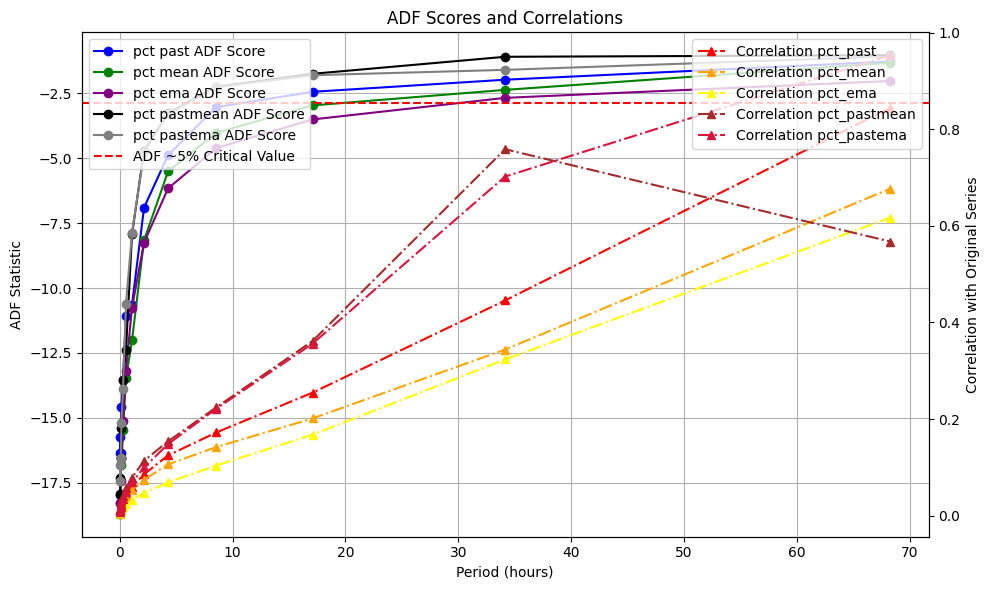

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

# Sample time series (replace with your own data)
np.random.seed(0)
series = data["close"][-(60*24*7*1):]  # pd.Series(np.cumsum(np.random.randn(500)) + 100
# Periods to analyze: [0, 1, 2, 4, 8, 16, 32, 64, ...]
lags = [2**i + 1 for i in range(13)]

pct_past_adf_scores = []
pct_mean_adf_scores = []
pct_ema_adf_scores = []
pct_pastmean_adf_scores = []
pct_pastema_adf_scores = []
cor_past_log = []
cor_mean_log = []
cor_ema_log = []
cor_pastmean_log = []
cor_pastema_log = []

for lag in tqdm(lags):
    pct_past = np.log1p(series.pct_change(periods=lag).fillna(0))
    pct_past_adf_scores.append(adfuller(pct_past)[0])
    cor_past_log.append(series.corr(pd.Series(pct_past, index=series.index)))

    pct_mean = np.log((series / series.rolling(lag).mean()).fillna(1))
    pct_mean_adf_scores.append(adfuller(pct_mean)[0])
    cor_mean_log.append(series.corr(pd.Series(pct_mean, index=series.index)))
    
    pct_ema = np.log((series / series.ewm(span=lag, adjust=False).mean()).fillna(1))
    pct_ema_adf_scores.append(adfuller(pct_ema)[0])
    cor_ema_log.append(series.corr(pd.Series(pct_ema, index=series.index)))
    
    pct_pastmean = np.log((series / series.rolling(lag).mean().shift(lag)).fillna(1))
    pct_pastmean_adf_scores.append(adfuller(pct_pastmean)[0])
    cor_pastmean_log.append(series.corr(pd.Series(pct_pastmean, index=series.index)))
    
    pct_pastema = np.log((series / series.ewm(span=lag, adjust=False).mean().shift(lag)).fillna(1))
    pct_pastema_adf_scores.append(adfuller(pct_pastema)[0])
    cor_pastema_log.append(series.corr(pd.Series(pct_pastema, index=series.index)))

lags = np.array(lags) / 60  # Convert lags to hours

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot ADF scores on primary y-axis
ax1.plot(lags, pct_past_adf_scores, marker='o', label='pct past ADF Score', color='blue')
ax1.plot(lags, pct_mean_adf_scores, marker='o', label='pct mean ADF Score', color='green')
ax1.plot(lags, pct_ema_adf_scores, marker='o', label='pct ema ADF Score', color='purple')
ax1.plot(lags, pct_pastmean_adf_scores, marker='o', label='pct pastmean ADF Score', color='black')
ax1.plot(lags, pct_pastema_adf_scores, marker='o', label='pct pastema ADF Score', color='gray')
ax1.axhline(-2.86, color='red', linestyle='--', label='ADF ~5% Critical Value')
ax1.set_xlabel('Period (hours)')
ax1.set_ylabel('ADF Statistic', color='black')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create secondary y-axis for correlations
ax2 = ax1.twinx()
ax2.plot(lags, cor_past_log, marker='^', label='Correlation pct_past', color='red', linestyle='-.')
ax2.plot(lags, cor_mean_log, marker='^', label='Correlation pct_mean', color='orange', linestyle='-.')
ax2.plot(lags, cor_ema_log, marker='^', label='Correlation pct_ema', color='yellow', linestyle='-.')
ax2.plot(lags, cor_pastmean_log, marker='^', label='Correlation pct_pastmean', color='brown', linestyle='-.')
ax2.plot(lags, cor_pastema_log, marker='^', label='Correlation pct_pastema', color='crimson', linestyle='-.')
ax2.set_ylabel('Correlation with Original Series', color='black')
ax2.legend(loc='upper right')

# Title and layout
plt.title('ADF Scores and Correlations')
plt.tight_layout()
plt.show()

- when balancing stationarity and memory(long term trends), we see:
- period < 20hrs = good stationarity
  - log or not
  - necessary
- period > 10hrs = good memory(trend info)
  - log prefered
  - not necessary, only if you want trend info


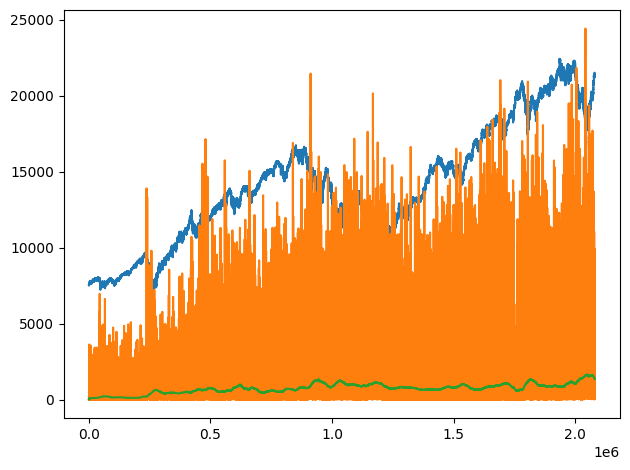

In [2]:
df = data.reset_index(drop=True)
plt.plot(df["close"])
plt.plot(df["volume"])
plt.plot(df["volume"].rolling(60*24*25*1, min_periods=1).mean())  # 1 month
plt.tight_layout()
plt.show()

In [ ]:

# Import Data
df = data
df = data[-(60*24*25*1):]
df.index.name = 'time'
df = df.reset_index()
# Generate 5min
m = 5
bars = []
price_buffer = []
volume_buffer = 0
for i, row in enumerate(df.itertuples()):
    if i % m == 0:
        # Set time directly from the current row
        time = row.time

    price_buffer.extend([row.open, row.high, row.low, row.close])
    volume_buffer += row.volume  # type: ignore

    if (i + 1) % m == 0:
        bars.append((
            time,
            price_buffer[0],           # open
            max(price_buffer),         # high
            min(price_buffer),         # low
            price_buffer[-1],          # close
            volume_buffer              # volume
        ))
        price_buffer = []
        volume_buffer = 0

time_bar = pd.DataFrame(bars, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
# time_bar.to_parquet(os.path.join(os.getcwd(), "time_bar.parquet"))
print(time_bar)

                time      open      high       low     close  volume
0       201906171300   7537.25   7537.25   7535.25   7536.50    12.0
1       201906171305   7536.25   7540.00   7536.25   7540.00    29.0
2       201906171310   7539.75   7541.50   7539.75   7540.50    18.0
3       201906171315   7540.75   7540.75   7539.25   7539.50     8.0
4       201906171325   7539.25   7540.00   7538.00   7538.25    20.0
...              ...       ...       ...       ...       ...     ...
416168  202505161235  21411.00  21412.75  21406.75  21410.25   393.0
416169  202505161240  21410.25  21413.00  21408.50  21412.25   326.0
416170  202505161245  21412.00  21414.50  21408.50  21413.25   520.0
416171  202505161250  21413.75  21418.75  21398.25  21400.75  2002.0
416172  202505161255  21400.75  21404.25  21399.75  21401.75   421.0

[416173 rows x 6 columns]


In [39]:
def find_imb_threshold(imbalances, target_bars):
    def compute_bar_count(x):
        acc = 0
        bar_count = 0
        for imb in imbalances:
            acc += imb
            if abs(acc) >= x:
                bar_count += 1
                acc = 0
        return bar_count

    # Define search bounds
    abs_imbs = [abs(imb) for imb in imbalances]
    assert any(abs_imbs), "At least one imbalance must be non-zero"
    x_min = min(imb for imb in abs_imbs if imb > 0)  # Smallest non-zero absolute imbalance
    x_max = sum(abs_imbs)  # Total absolute imbalance

    # Binary search with early stopping and max iterations
    while True:
        x_mid = (x_min + x_max) * 0.5
        bars = compute_bar_count(x_mid)
        if (abs(bars - target_bars) <= 5) or (x_max - x_min < 1):
            return (x_min + x_max) * 0.5  # Return mean of last two x values
        if bars > target_bars:
            x_min = x_mid  # Too many bars, increase threshold
        else:
            x_max = x_mid  # Too few or equal bars, decrease threshold

def find_run_threshold(runs, target_bars):
    """
    Determines the dynamic threshold x such that splitting the daily runs volumes
    into bars based on cumulative sum >= x yields approximately target_bars.
    """
    def compute_bar_count(x):
        acc = 0.0
        bar_count = 0
        for run in runs:
            acc += run
            if acc >= x:
                bar_count += 1
                acc = 0.0
        return bar_count

    # Ensure positive run values
    assert any(runs), "At least one run value must be non-zero"
    x_min = min(r for r in runs if r > 0)
    x_max = sum(runs)

    # Binary search to find threshold
    for _ in range(50):  # max iterations
        x_mid = 0.5 * (x_min + x_max)
        bars = compute_bar_count(x_mid)
        # Accept if within tolerance of +/-5 bars or convergence
        if abs(bars - target_bars) <= 5 or (x_max - x_min) < 1e-6:
            return x_mid
        if bars > target_bars:
            x_min = x_mid
        else:
            x_max = x_mid
    return 0.5 * (x_min + x_max)

def proc_volume_imbalance_bar(df):
    """
    Measures the relative directional volume imbalance
    """
    df['date'] = df['time'].apply(lambda x: int(str(x)[:8]))
    df['label'] = np.sign(df['close'].pct_change()).replace(0, np.nan).ffill().fillna(0).astype(int)
    df['imb'] = df['label'] * df['volume']

    # Initialize variables
    t = 1                                 # original sampling period (min)
    p = 6.5                               # expected equivalent period (min)
    expected_daily_bars = int(60/t*24/p)  # Expected number of bars per day (p min bar)
    N = 7*2                               # Number of days to use for EMA calculation
    alpha = 2 / (N + 1)                   # EMA smoothing factor
    ema_thresh = None                     # Start with no threshold
    bars = []
    daily_imbs = []                       # Track daily imbalances
    daily_count = 0                       # Count bars per day

    # Accumulators for bar formation
    cumm_imb, cumm_vol, cumm_dollar = 0, 0, 0
    price_buffer = []
    prev_date = df['date'].iloc[0]

    for i, (time, date, open, high, low, close, imb, volume) in enumerate(zip(df['time'], df['date'], df['open'], df['high'], df['low'], df['close'], df['imb'], df['volume'])):
        # New day: update threshold based on previous day's data
        if date != prev_date:
            if len(daily_imbs) > 60*2 and daily_count > 0:
                # Estimate threshold: total imbalance / target bars
                daily_thresh = find_imb_threshold(daily_imbs, expected_daily_bars)
                ema_thresh = daily_thresh if ema_thresh is None else (alpha * daily_thresh + (1 - alpha) * ema_thresh)
            daily_imbs = []
            daily_count = 0
            prev_date = date

        # Calculate imbalance
        daily_imbs.append(imb)

        # Accumulate for bar formation
        cumm_imb += imb
        cumm_vol += volume
        cumm_dollar += close * volume
        price_buffer.extend([open, high, low, close])

        # Use current EMA threshold (default to 0 for first day)
        thresh = ema_thresh if ema_thresh is not None else 0

        # Form a bar if threshold exceeded
        if abs(cumm_imb) >= thresh:
            open = price_buffer[0]
            high = np.max(price_buffer)
            low = np.min(price_buffer)
            close_price = price_buffer[-1]
            vwap = cumm_dollar / cumm_vol if cumm_vol > 0 else close_price
            bars.append((time, date, open, high, low, close_price, vwap, thresh))
            daily_count += 1

            # Reset accumulators
            cumm_imb, cumm_vol, cumm_dollar = 0, 0, 0
            price_buffer = []

    # Return bars as DataFrame
    return pd.DataFrame(bars, columns=['time', 'date', 'open', 'high', 'low', 'close', 'vwap', 'thresh'])


def proc_volume_run_bar(df):
    """
    Measures the absolute directional volume
    """
    df['date'] = df['time'].apply(lambda x: int(str(x)[:8]))
    df['label'] = np.sign(df['close'].pct_change()).replace(0, np.nan).ffill().fillna(0).astype(int)
    df['buy_vol'] = df['volume'].where(df['label'] == 1, 0)
    df['sell_vol'] = df['volume'].where(df['label'] == -1, 0)

    # Parameters for dynamic threshold
    t = 1                                 # original sampling period (min)
    p = 3.5                               # target bar length (min)
    expected_daily_bars = int(60/t * 24 / p)
    N = 7 * 2                             # lookback days for EMA
    alpha = 2 / (N + 1)                   # EMA smoothing factor
    ema_thresh = None                     # EMA of daily run volumes

    # Containers
    bars = []
    daily_runs = []                       # store completed run volumes per day
    daily_count = 0
    prev_date = df['date'].iloc[0]

    # Accumulators for bar formation
    cumm_buy, cumm_sell = 0.0, 0.0
    cumm_vol, cumm_dollar = 0.0, 0.0
    price_buffer = []

    for time, date, o, h, l, c, label, buy_v, sell_v, vol in zip(df['time'], df['date'], df['open'], df['high'], df['low'], df['close'], df['label'], df['buy_vol'], df['sell_vol'], df['volume']):
        # New day: update EMA threshold from previous day's runs
        if date != prev_date:
            if len(daily_runs) >= expected_daily_bars and daily_count > 0:
                # compute daily threshold: split daily runs into expected bars
                daily_thresh = find_run_threshold(daily_runs, expected_daily_bars)
                ema_thresh = (daily_thresh if ema_thresh is None else alpha * daily_thresh + (1 - alpha) * ema_thresh)
            daily_runs = []
            daily_count = 0
            prev_date = date

        # Accumulate side volumes
        cumm_buy += buy_v
        cumm_sell += sell_v
        cumm_vol += vol
        cumm_dollar += c * vol
        price_buffer.extend([o, h, l, c])

        # Compute run metric: dominant side volume
        theta = max(cumm_buy, cumm_sell)
        # Current threshold (0 for first day)
        thresh = ema_thresh if ema_thresh is not None else 0

        # Trigger bar formation
        if theta >= thresh:
            open_price = price_buffer[0]
            high_price = np.max(price_buffer)
            low_price = np.min(price_buffer)
            close_price = price_buffer[-1]
            vwap = cumm_dollar / cumm_vol if cumm_vol > 0 else close_price

            bars.append((time, date, open_price, high_price,
                         low_price, close_price, vwap, thresh))
            # Record this bar's run volume
            daily_runs.append(theta)
            daily_count += 1

            # Reset accumulators
            cumm_buy, cumm_sell = 0.0, 0.0
            cumm_vol, cumm_dollar = 0.0, 0.0
            price_buffer = []

    return pd.DataFrame(bars, columns=['time', 'date', 'open', 'high', 'low', 'close', 'vwap', 'thresh'])

if __name__ == '__main__':
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    import seaborn as sns
    import scipy.stats as stats

    # Import Data
    df = data
    df = data[-(60*24*25*1):]
    df.index.name = 'time'
    df = df.reset_index()

    # Generate imbalance bars
    # vimb_bar = proc_volume_imbalance_bar(df)
    # vimb_bar.to_parquet(os.path.join(os.getcwd(), "volume_imbalance_bar.parquet"))
    # print(bar_vimb.shape)

    # Generate run bars
    vrun_bar = proc_volume_run_bar(df)
    # vrun_bar.to_parquet(os.path.join(os.getcwd(), "volume_run_bar.parquet"))
    # print(vrun_bar.shape)

    

    # Plot bars
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['time'], y=df['close'], mode='lines', name='Time bar'))
    # fig.add_trace(go.Candlestick(x=vimb_bar['time'], open=vimb_bar['open'], high=vimb_bar['high'], low=vimb_bar['low'], close=vimb_bar['close'], name='Volume imbalance bar'))
    fig.add_trace(go.Candlestick(x=vrun_bar['time'], open=vrun_bar['open'], high=vrun_bar['high'], low=vrun_bar['low'], close=vrun_bar['close'], name='Volume run bar'))
    fig.update_layout(
        title='Sampling methods',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        xaxis=dict(type='category')  # This thickens the candle visually
    )
    fig.show()

In [35]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gaussian_kde
import plotly.graph_objects as go

raw_bar = pd.read_parquet(os.path.join(os.getcwd(), 'history.parquet'))
time_bar = pd.read_parquet(os.path.join(os.getcwd(), 'time_bar.parquet'))
vimb_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_imbalance_bar.parquet'))
vrun_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_run_bar.parquet'))
print(raw_bar.shape[0])
print(time_bar.shape[0])
print(vimb_bar.shape[0])
print(vrun_bar.shape[0])

# Constants
MAX = 0.02
MIN = -0.02
BIN = 500
x = np.linspace(-3, 3, BIN)

# Create figure
fig = go.Figure()

# Standard Normal curve
standard_pdf = norm.pdf(x, 0, 1)
fig.add_trace(go.Scatter(
    x=x, y=standard_pdf,
    mode='lines',
    name='Standard Normal',
    line=dict(color='black', dash='dash', width=2),
    legendgroup='normal',
    legendgrouptitle_text='Reference'
))


def add_hist(data: pd.DataFrame, period_list, label: str, color: str):
    alphas = np.linspace(0.2, 1.0, len(period_list))
    for period, alpha in zip(period_list, alphas):
        data_sub = data[-(60*24*25*5):]
        returns = np.log1p(data_sub["close"].pct_change(periods=period).fillna(0))
        mu, std = norm.fit(returns)
        standardized_returns = (returns - mu) / std
        kde = gaussian_kde(standardized_returns, bw_method=0.05)
        fig.add_trace(go.Scatter(
            x=x, y=kde(x),
            mode='lines',
            name=f'{label} (p={period})',
            line=dict(color=color, width=2),
            opacity=alpha,
            legendgroup=label,
            legendgrouptitle_text=label
        ))


# Periods
periods = [1, 2, 4, 16, 64, 256]

# Add data groups with color
add_hist(raw_bar, periods, '1min Bar', 'blue')
add_hist(time_bar, periods, '5min Bar', 'orange')
add_hist(vimb_bar, periods, 'volume imbalance Bar', 'green')
add_hist(vrun_bar, periods, 'volume run Bar', 'purple')

# Layout
fig.update_layout(
    title='Standardized Return KDEs',
    xaxis_title='Standardized Return',
    yaxis_title='Density',
    template='plotly_white',
    legend=dict(
        orientation="v",
        x=1.02,
        y=1,
        tracegroupgap=5
    ),
    width=1000,
    height=600
)

fig.show()

2115310
416173
416903
413636
